In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:

tesla = pd.read_csv('tesla_stocks.csv')
tesla.head()

,Date,Open,High,Low,Close,Volume
0,2-Aug-17,318.94,327.12,311.22,325.89,13091462
1,1-Aug-17,323.00,324.45,316.13,319.57,8303102
2,31-Jul-17,335.50,341.49,321.04,323.47,8535136
3,28-Jul-17,336.89,339.60,332.51,335.07,4880414
4,27-Jul-17,346.00,347.50,326.29,334.46,8302405


In [3]:
data = tesla['Close'].values

In [4]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.reshape(-1,1))

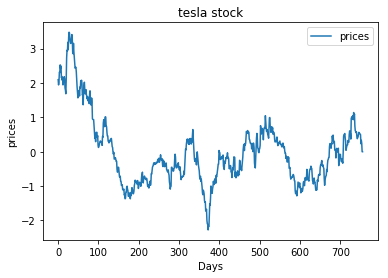

In [5]:
plt.figure(edgecolor='red')
plt.title('tesla stock')
plt.xlabel('Days')
plt.ylabel('prices')
plt.plot(scaled_data, label='prices')
plt.legend()
plt.show()

In [16]:
def train_data(data, input_size):
    X = []
    Y = []
    i = 0
    while (i + input_size) <= len(data) - 1:
        X.append(data[i:i+input_size])
        Y.append(data[i+input_size])
        i += 1
    assert len(X) == len(Y)
    return X,Y

X, Y = train_data(scaled_data, 7)
X[0],Y[0]

(array([[ 2.09666484],
        [ 1.94507542],
        [ 2.03861952],
        [ 2.31685325],
        [ 2.302222  ],
        [ 2.52744741],
        [ 2.42550832]]), array([ 2.49554647]))

In [8]:
X, y = window_data(scaled_data, 7)

In [108]:
batch_size = 50
train, test = 0.8, 0.2
train_end = int(len(data)*0.8)
test_start = train_end
X_train = X[:train_end]
Y_train = Y[:train_end]
X_test= X[test_start:]
Y_test = Y[test_start:]
tf.reset_default_graph()
n_neurons = 512   #neurons that inside of each one time network
prob = 0.7        #dropout probability 30%
is_training = None    #training mode
number_layers = 5        #multiple RNN layers
#hidden_layer_number = 700
output_size = 1
input_size = 1
time_series = 7         #unrolled time
learning_rate = 0.001
X_ = tf.placeholder(tf.float32, shape=(None, time_series, input_size), name='X')
Y_ = tf.placeholder(tf.float32, shape=(None, output_size), name='Y')
batch = tf.placeholder(tf.int32, name='batch')
is_training = tf.placeholder(tf.bool, name="training_mode")
clip_threshold = 3    

with tf.name_scope('LSTM'):
    ###initializer stagery has been used
    layers = tf.contrib.rnn.OutputProjectionWrapper(
        tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons),output_size=1)
    #layers = [cell for layer in range(number_layers) ]
    
    ### dropout reduce the risk of overfitting
    #if is_training is not None:
       # layers = [tf.contrib.rnn.DropoutWrapper(layer, input_keep_prob=prob) for layer in layers]
    #stacked_layers = tf.contrib.rnn.MultiRNNCell(layers)
    #init_state = stacked_layers.zero_state(batch_size, tf.float32)
    outputs, states = tf.nn.dynamic_rnn(layers, X_, dtype=tf.float32)

with tf.name_scope('fc1'):
    #stacked_outputs = tf.reshape(outputs,[-1,n_neurons])
    #stacked_outputs.shape
    #stacked_output = stacked_outputs[-1]
    output_change = tf.reshape(outputs,(time_series, -1, 1))
    logits = output_change[-1]
    #hidden_1 = tf.layers.dense(n_neurons, hidden_layer_number, name='hidden', activation=tf.nn.relu)
    #logits = tf.layers.dense(last_output,output_size, name='logits', activation=None)
    #logits_outputs = tf.reshape(logits, [-1, time_series, output_size])

with tf.name_scope('train'):
    #loss = tf.losses.mean_squared_error(logits, Y_)
    
    loss = tf.reduce_mean(tf.square(logits-Y_))
    #loss = tf.reduce_sum(losses)/(2*batch_size)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    
    ###
    ###clip can reduce the gradient explore problem
    ###
    #grads_and_vars = optimizer.compute_gradients(loss)
    #capped_gvs = [(tf.clip_by_value(grad, -clip_threshold, clip_threshold), var) for grad, var in grads_and_vars]
    #training_op = optimizer.apply_gradients(capped_gvs)
    training_op = optimizer.minimize(loss)
  

Epoch 0/5  Current loss: 0.11353211104869843
Epoch 2/5  Current loss: 0.04864950850605965
Epoch 4/5  Current loss: 0.04299686476588249


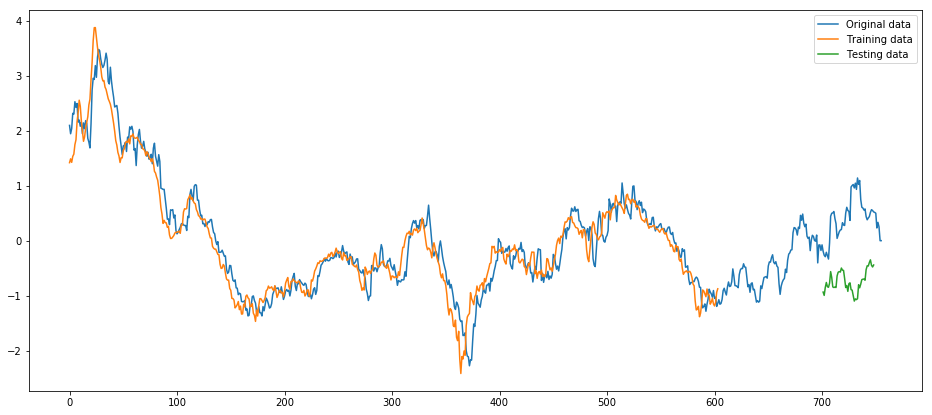

In [111]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

X_train = np.array(X_train)
X_train = X_train.reshape((-1,7,1))
Y_train = np.array(Y_train)
Y_train = Y_train.reshape((-1,1))
epochs = 5
best_loss = np.infty
max_tolerate = 60
with tf.Session() as sess:
    init.run()
    """
    for epoch in range(epochs):
        for i in range(int(train_end/batch_size)+1):
            #f train_end >= (i+1)*batch_size:
                X_batch = X[i*batch_size:(i+1)*batch_size]
                X_batch = np.array(X_batch)
                X_batch = X_batch.reshape((-1,7,1))
                Y_batch = Y[i*batch_size:(i+1)*batch_size]
                Y_batch = np.array(Y_batch)
                Y_batch = Y_batch.reshape((-1,1))
                #print(len(X_batch))
            else:
                X_batch = X[i*batch_size:train_end]
                X_batch = np.array(X_batch)
                X_batch = X_batch.reshape((-1,7,1))
                Y_batch = Y[i*batch_size:train_end]
                Y_batch = np.array(Y_batch)
                Y_batch = Y_batch.reshape((-1,1))
            a, b, c, d = sess.run([outputs, output_change, logits, training_op, ], feed_dict={X_:X_batch, Y_:Y_batch})
            print(a, b, c, d)
            #is_training = True
            #print(Y_batch.shape)
    """
    for epoch in range(epochs):
        traind_scores = []
        epoch_loss = []
        for numbe in range(X_train.shape[0]):
            X_batch = np.array(X)
            X_batch = X_batch.reshape((-1,7,1))

            Y_batch = np.array(Y)
            Y_batch = Y_batch.reshape((-1,1))
            X_fan = X_batch[numbe].reshape((-1,7,1))
            Y_fan = Y_batch[numbe].reshape((-1,1))
            a, b, c, d,e = sess.run(
                [outputs, output_change, logits,loss, training_op, ], feed_dict={X_:X_fan, Y_:Y_fan})
            epoch_loss.append(d)
            traind_scores.append(c)
            #print(traind_scores)
        if (epoch % 2) == 0:
            print('Epoch {}/{}'.format(epoch, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
    sup =[]
    for i in range(len(traind_scores)):
        for j in range(len(traind_scores[i])):
                #print()
            sup.append(traind_scores[i][j])
                #print(i,j)
    tests = []
    diao = 0
    while diao+1 <= len(X_test):
        o = sess.run(logits, feed_dict={X_:X_test[diao:diao+1]})
        diao += 1
        tests.append(o)
    tests_new = []
    for i in range(len(tests)):
        for j in range(len(tests[i][0])):
            tests_new.append(tests[i][0][j])
    test_results = []
    for i in range(749):
        if i >= 604:
            test_results.append(tests_new[i-701])
        else:
            test_results.append(None)
        """
    for diao in range(len(X)):
        X_heng = X[diao].reshape((-1,7,1))
        o = sess.run(logits, feed_dict={X_:X_heng})
        tests.append(o)
        """
    """
    tests_new = []
    for i in range(len(tests)):
        for j in range(len(tests[i][0])):
            tests_new.append(tests[i][0][j])
    test_results = []
    for i in range(749):
        if i >= 701:
            test_results.append(tests_new[i-701])
        else:
            test_results.append(None)
    """
    plt.figure(figsize=(16, 7))
    plt.plot(scaled_data, label='Original data')
    plt.plot(sup, label='Training data')
    plt.plot(test_results, label='Testing data')
    plt.legend()
    plt.show()
        #print(np.sum(np.square(c-Y_batch))/(749))
        #print(Y_batch.shape)
            #print(d)
        #print(Y_batch[:10])
            #is_training = True
            #print(Y_batch.shape)
           
         ###
        ###early stop to prevent overfitting
        ###
        

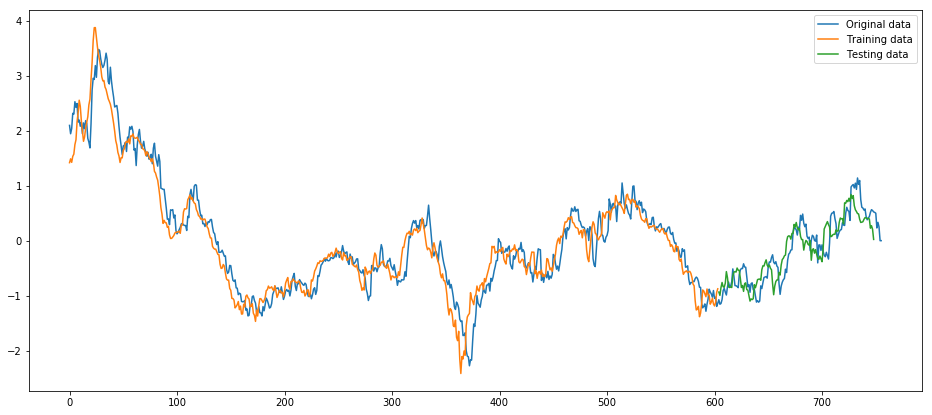

In [116]:
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])
test_results = []
for i in range(749):
    if i >= 604:
        test_results.append(tests_new[i-604])
    else:
        test_results.append(None)
plt.figure(figsize=(16, 7))
plt.plot(scaled_data, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()

In [120]:
for i in range(len(tests)):
    print(tests[i])
    #for j in range(len(tests[i][0])):
        #print()

[[-0.93373418]]
[[-0.99421823]]
[[-0.85155565]]
[[-0.7592473]]
[[-0.83655751]]
[[-0.84672189]]
[[-0.7727229]]
[[-0.56169498]]
[[-0.66801882]]
[[-0.840276]]
[[-0.8511911]]
[[-0.84180433]]
[[-0.85131073]]
[[-0.63959569]]
[[-0.57318753]]
[[-0.56120491]]
[[-0.57016462]]
[[-0.49689731]]
[[-0.53528255]]
[[-0.53988481]]
[[-0.6855939]]
[[-0.85107589]]
[[-0.81424564]]
[[-0.92100126]]
[[-0.78043669]]
[[-0.76561517]]
[[-0.88934869]]
[[-0.89856756]]
[[-0.9974345]]
[[-1.09774077]]
[[-1.05811846]]
[[-1.07098556]]
[[-1.05399656]]
[[-0.80076635]]
[[-0.85592794]]
[[-0.78917414]]
[[-0.70720965]]
[[-0.69956946]]
[[-0.69635081]]
[[-0.71852326]]
[[-0.52596301]]
[[-0.45566726]]
[[-0.46050447]]
[[-0.39670232]]
[[-0.34773722]]
[[-0.44558915]]
[[-0.47772092]]
[[-0.44190171]]
[[-0.50113553]]
[[-0.52831584]]
[[-0.78073937]]
[[-0.98218733]]
[[-0.82597154]]
[[-0.74210376]]
[[-0.71314979]]
[[-0.71214503]]
[[-0.5769071]]
[[-0.62363124]]
[[-0.44246688]]
[[-0.34364706]]
[[-0.31866458]]
[[-0.27467105]]
[[-0.25988039]]


Epoch 0/5  Current loss: 0.11526500433683395
Epoch 2/5  Current loss: 0.04836912453174591
Epoch 4/5  Current loss: 0.04271253943443298


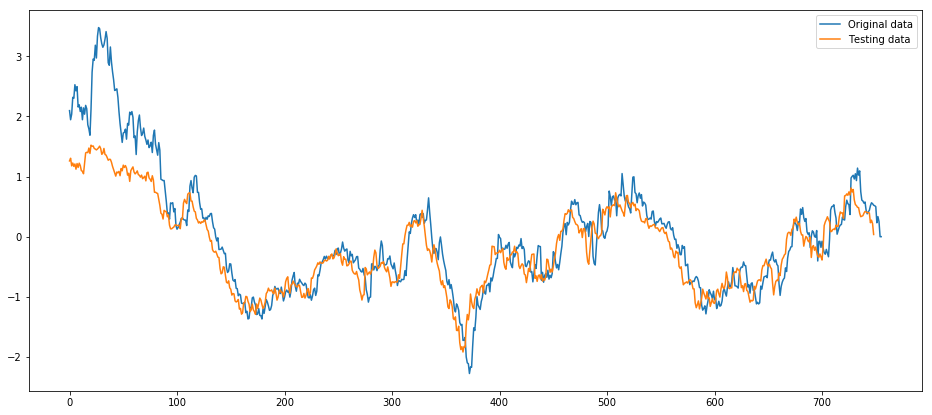

In [122]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

X_train = np.array(X_train)
X_train = X_train.reshape((-1,7,1))
Y_train = np.array(Y_train)
Y_train = Y_train.reshape((-1,1))
epochs = 5
best_loss = np.infty
max_tolerate = 60
with tf.Session() as sess:
    init.run()
    for epoch in range(epochs):
        traind_scores = []
        epoch_loss = []
        for numbe in range(X_train.shape[0]):
            X_batch = np.array(X)
            X_batch = X_batch.reshape((-1,7,1))

            Y_batch = np.array(Y)
            Y_batch = Y_batch.reshape((-1,1))
            X_fan = X_batch[numbe].reshape((-1,7,1))
            Y_fan = Y_batch[numbe].reshape((-1,1))
            a, b, c, d,e = sess.run(
                [outputs, output_change, logits,loss, training_op, ], feed_dict={X_:X_fan, Y_:Y_fan})
            epoch_loss.append(d)
            traind_scores.append(c)
            #print(traind_scores)
        if (epoch % 2) == 0:
            print('Epoch {}/{}'.format(epoch, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
    sup =[]
    for i in range(len(traind_scores)):
        for j in range(len(traind_scores[i])):
                #print()
            sup.append(traind_scores[i][j])
                #print(i,j)
    tests = []
    diao = 0
    while diao+1 <= len(X):
        o = sess.run(logits, feed_dict={X_:X[diao:diao+1]})
        diao += 1
        tests.append(o)
    tests_new = []
    for i in range(len(tests)):
        for j in range(len(tests[i][0])):
            tests_new.append(tests[i][0][j])
    test_results = []
    for i in range(749):
        test_results.append(tests_new[i-749])
       
    plt.figure(figsize=(16, 7))
    plt.plot(scaled_data, label='Original data')
    #plt.plot(sup, label='Training data')
    plt.plot(test_results, label='Testing data')
    plt.legend()
    plt.show()

Epoch 0/1000  Current loss: 1.1400704383850098
Epoch 2/1000  Current loss: 1.0586133003234863
Epoch 4/1000  Current loss: 1.0271198749542236
Epoch 6/1000  Current loss: 1.0235393047332764
Epoch 8/1000  Current loss: 1.0085877180099487
Epoch 10/1000  Current loss: 0.9969927072525024
Epoch 12/1000  Current loss: 0.9913267493247986
Epoch 14/1000  Current loss: 0.9815822243690491
Epoch 16/1000  Current loss: 0.9633594155311584
Epoch 18/1000  Current loss: 0.9395402073860168
Epoch 20/1000  Current loss: 0.9151949882507324
Epoch 22/1000  Current loss: 0.8746776580810547
Epoch 24/1000  Current loss: 0.8560376763343811
Epoch 26/1000  Current loss: 0.8498649597167969
Epoch 28/1000  Current loss: 0.8269824385643005
Epoch 30/1000  Current loss: 0.8062421083450317
Epoch 32/1000  Current loss: 0.7937535047531128
Epoch 34/1000  Current loss: 0.7908318042755127
Epoch 36/1000  Current loss: 0.7920782566070557
Epoch 38/1000  Current loss: 0.7745226621627808
Epoch 40/1000  Current loss: 0.75330686569213

Epoch 336/1000  Current loss: 0.4178425073623657
Epoch 338/1000  Current loss: 0.4091796278953552
Epoch 340/1000  Current loss: 0.40809395909309387
Epoch 342/1000  Current loss: 0.408801406621933
Epoch 344/1000  Current loss: 0.40838155150413513
Epoch 346/1000  Current loss: 0.4067414104938507
Epoch 348/1000  Current loss: 0.40471991896629333
Epoch 350/1000  Current loss: 0.40288737416267395
Epoch 352/1000  Current loss: 0.40132835507392883
Epoch 354/1000  Current loss: 0.4000224471092224
Epoch 356/1000  Current loss: 0.39887097477912903
Epoch 358/1000  Current loss: 0.398281991481781
Epoch 360/1000  Current loss: 0.39708688855171204
Epoch 362/1000  Current loss: 0.3953269422054291
Epoch 364/1000  Current loss: 0.3947766125202179
Epoch 366/1000  Current loss: 0.39389193058013916
Epoch 368/1000  Current loss: 0.39235252141952515
Epoch 370/1000  Current loss: 0.39178749918937683
Epoch 372/1000  Current loss: 0.3902795612812042
Epoch 374/1000  Current loss: 0.38950854539871216
Epoch 376/1

Epoch 668/1000  Current loss: 0.32750892639160156
Epoch 670/1000  Current loss: 0.3470970690250397
Epoch 672/1000  Current loss: 0.33330607414245605
Epoch 674/1000  Current loss: 0.3193727433681488
Epoch 676/1000  Current loss: 0.31505125761032104
Epoch 678/1000  Current loss: 0.3220129609107971
Epoch 680/1000  Current loss: 0.3210255205631256
Epoch 682/1000  Current loss: 0.3144857883453369
Epoch 684/1000  Current loss: 0.3127540051937103
Epoch 686/1000  Current loss: 0.31348589062690735
Epoch 688/1000  Current loss: 0.3129137456417084
Epoch 690/1000  Current loss: 0.30776622891426086
Epoch 692/1000  Current loss: 0.3083905875682831
Epoch 694/1000  Current loss: 0.30679377913475037
Epoch 696/1000  Current loss: 0.3056895136833191
Epoch 698/1000  Current loss: 0.303425669670105
Epoch 700/1000  Current loss: 0.30197033286094666
Epoch 702/1000  Current loss: 0.30124807357788086
Epoch 704/1000  Current loss: 0.3008284270763397
Epoch 706/1000  Current loss: 0.29989150166511536
Epoch 708/10

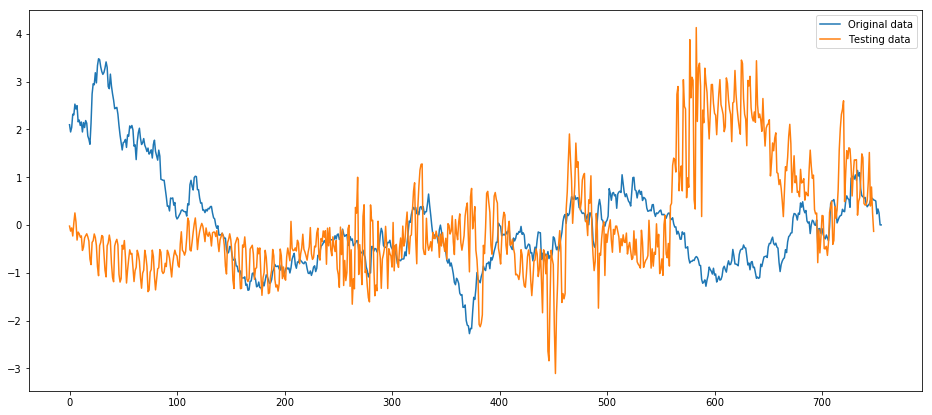

In [133]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

X_train = np.array(X_train)
X_train = X_train.reshape((-1,7,1))
Y_train = np.array(Y_train)
Y_train = Y_train.reshape((-1,1))
epochs = 1000
best_loss = np.infty
max_tolerate = 60
with tf.Session() as sess:
    init.run()
    for epoch in range(epochs):
        traind_scores = []
        epoch_loss = []
        X_batch = np.array(X_train)
        X_batch = X_batch.reshape((-1,7,1))

        Y_batch = np.array(Y_train)
        Y_batch = Y_batch.reshape((-1,1))
        #X_fan = X_batch[numbe].reshape((-1,7,1))
        #Y_fan = Y_batch[numbe].reshape((-1,1))
        a, b, c, d,e = sess.run(
            [outputs, output_change, logits,loss, training_op, ], feed_dict={X_:X_batch, Y_:Y_batch})
        epoch_loss.append(d)
        traind_scores.append(c)
        #print(traind_scores)
        if (epoch % 2) == 0:
            print('Epoch {}/{}'.format(epoch, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
    sup =[]
    for i in range(len(traind_scores)):
        for j in range(len(traind_scores[i])):
                #print()
            sup.append(traind_scores[i][j])
                #print(i,j)
    tests = []
    diao = 0
    #while diao+1 <= len(X):
    o = sess.run(logits, feed_dict={X_:X})
        #diao += 1
    tests.append(o)
    tests_new = []
    for i in range(len(tests)):
        for j in range(len(tests[i])):
            tests_new.append(tests[i][j])
    test_results = []
    for i in range(749):
        test_results.append(tests_new[i-749])
       
    plt.figure(figsize=(16, 7))
    plt.plot(scaled_data, label='Original data')
    #plt.plot(sup, label='Training data')
    plt.plot(test_results, label='Testing data')
    plt.legend()
    plt.show()

Epoch 0/5  Current loss: 0.1258685141801834
Epoch 2/5  Current loss: 0.0611240454018116
Epoch 4/5  Current loss: 0.05397443473339081


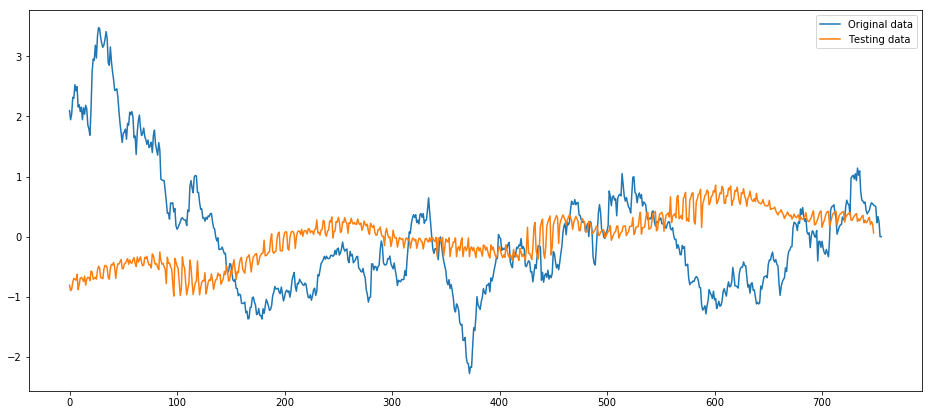

In [139]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

X_train = np.array(X_train)
X_train = X_train.reshape((-1,7,1))
Y_train = np.array(Y_train)
Y_train = Y_train.reshape((-1,1))
epochs = 5
best_loss = np.infty
max_tolerate = 60
with tf.Session() as sess:
    init.run()
    for epoch in range(epochs):
        traind_scores = []
        epoch_loss = []
        for numbe in range(X_train.shape[0]):
            X_batch = np.array(X)
            X_batch = X_batch.reshape((-1,7,1))

            Y_batch = np.array(Y)
            Y_batch = Y_batch.reshape((-1,1))
            X_fan = X_batch[numbe].reshape((-1,7,1))
            Y_fan = Y_batch[numbe].reshape((-1,1))
            a, b, c, d,e = sess.run(
                [outputs, output_change, logits,loss, training_op, ], feed_dict={X_:X_fan, Y_:Y_fan})
            epoch_loss.append(d)
            traind_scores.append(c)
            #print(traind_scores)
        if (epoch % 2) == 0:
            print('Epoch {}/{}'.format(epoch, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
    sup =[]
    for i in range(len(traind_scores)):
        for j in range(len(traind_scores[i])):
                #print()
            sup.append(traind_scores[i][j])
                #print(i,j)
    tests = []
    diao = 0
    #while diao+1 <= len(X):
    o = sess.run(logits, feed_dict={X_:X})
        #diao += 1
    tests.append(o)
    tests_new = []
    for i in range(len(tests)):
        for j in range(len(tests[i])):
            tests_new.append(tests[i][j])
    test_results = []
    for i in range(749):
        test_results.append(tests_new[i-749])
       
    plt.figure(figsize=(16, 7))
    plt.plot(scaled_data, label='Original data')
    #plt.plot(sup, label='Training data')
    plt.plot(test_results, label='Testing data')
    plt.legend()
    plt.show()

In [141]:
o

array([[-0.80603343],
       [-0.89634037],
       [-0.87228698],
       [-0.75851214],
       [-0.69306356],
       [-0.70632726],
       [-0.72153848],
       [-0.62387341],
       [-0.87836814],
       [-0.79564136],
       [-0.68556106],
       [-0.67717725],
       [-0.7020089 ],
       [-0.74249518],
       [-0.65602332],
       [-0.80373961],
       [-0.70512378],
       [-0.67355567],
       [-0.68012923],
       [-0.72715992],
       [-0.57161409],
       [-0.58589774],
       [-0.70647079],
       [-0.69071043],
       [-0.67310995],
       [-0.70460951],
       [-0.55629426],
       [-0.48997834],
       [-0.52352107],
       [-0.68062174],
       [-0.68404645],
       [-0.69753665],
       [-0.53610426],
       [-0.47555143],
       [-0.48368412],
       [-0.51832479],
       [-0.67286229],
       [-0.70587379],
       [-0.52664804],
       [-0.45860445],
       [-0.47063723],
       [-0.42699945],
       [-0.5131287 ],
       [-0.69309419],
       [-0.53205788],
       [-0

In [130]:
tests[0][2]

array([-0.25493976], dtype=float32)

In [121]:
X

[array([[ 2.09666484],
        [ 1.94507542],
        [ 2.03861952],
        [ 2.31685325],
        [ 2.302222  ],
        [ 2.52744741],
        [ 2.42550832]]), array([[ 1.94507542],
        [ 2.03861952],
        [ 2.31685325],
        [ 2.302222  ],
        [ 2.52744741],
        [ 2.42550832],
        [ 2.49554647]]), array([[ 2.03861952],
        [ 2.31685325],
        [ 2.302222  ],
        [ 2.52744741],
        [ 2.42550832],
        [ 2.49554647],
        [ 2.15686886]]), array([[ 2.31685325],
        [ 2.302222  ],
        [ 2.52744741],
        [ 2.42550832],
        [ 2.49554647],
        [ 2.15686886],
        [ 2.19332707]]), array([[ 2.302222  ],
        [ 2.52744741],
        [ 2.42550832],
        [ 2.49554647],
        [ 2.15686886],
        [ 2.19332707],
        [ 2.08155387]]), array([[ 2.52744741],
        [ 2.42550832],
        [ 2.49554647],
        [ 2.15686886],
        [ 2.19332707],
        [ 2.08155387],
        [ 2.15303115]]), array([[ 2.42550832],
     

In [104]:
dongdong = []
for la in range(len(tests)):
    for ga in tests[la]:
        dongdong.append(ga[0])
dongdong

[-1.7399404,
 -1.7401013,
 -1.7499051,
 -1.7418858,
 -1.7470812,
 -1.7396336,
 -1.7498338,
 -1.7404962,
 -1.7523063,
 -1.7452973,
 -1.7503616,
 -1.7585531,
 -1.7647716,
 -1.7655841,
 -1.7504808,
 -1.7292533,
 -1.7238009,
 -1.7290171,
 -1.7239102,
 -1.7311711,
 -1.7120968,
 -1.6965524,
 -1.692504,
 -1.695994,
 -1.6945593,
 -1.6996062,
 -1.6929778,
 -1.6886166,
 -1.6858615,
 -1.6904076,
 -1.7026246,
 -1.7049758,
 -1.6967912,
 -1.7017796,
 -1.7043623,
 -1.7104985,
 -1.7230827,
 -1.7232311,
 -1.7182344,
 -1.7271248,
 -1.738288,
 -1.7481397,
 -1.7578484,
 -1.7639271,
 -1.7569901,
 -1.7605428,
 -1.7627772,
 -1.7742413,
 -1.7662705,
 -1.7717708,
 -1.7595068,
 -1.7616812,
 -1.7580277,
 -1.7650949,
 -1.7727875,
 -1.7709626,
 -1.781201,
 -1.7642606,
 -1.7586147,
 -1.7563289,
 -1.771397,
 -1.7755257,
 -1.7790049,
 -1.7693995,
 -1.7711226,
 -1.7708958,
 -1.7788683,
 -1.7782065,
 -1.783373,
 -1.7795454,
 -1.7804512,
 -1.7892183,
 -1.7773,
 -1.7745043,
 -1.7856632,
 -1.7879843,
 -1.791551,
 -1.78461

In [112]:
X_train.shape

(604, 7, 1)

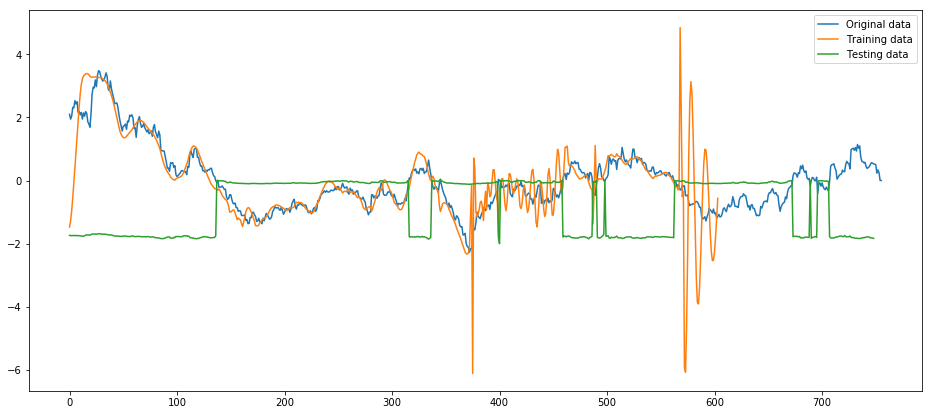

In [107]:
plt.figure(figsize=(16, 7))
plt.plot(scaled_data, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(dongdong, label='Testing data')
plt.legend()
plt.show()

In [105]:
tests

[array([[-1.7399404]], dtype=float32),
 array([[-1.74010134]], dtype=float32),
 array([[-1.74990511]], dtype=float32),
 array([[-1.74188578]], dtype=float32),
 array([[-1.74708116]], dtype=float32),
 array([[-1.73963356]], dtype=float32),
 array([[-1.74983382]], dtype=float32),
 array([[-1.74049616]], dtype=float32),
 array([[-1.75230634]], dtype=float32),
 array([[-1.74529731]], dtype=float32),
 array([[-1.75036156]], dtype=float32),
 array([[-1.75855315]], dtype=float32),
 array([[-1.76477158]], dtype=float32),
 array([[-1.76558411]], dtype=float32),
 array([[-1.75048077]], dtype=float32),
 array([[-1.72925329]], dtype=float32),
 array([[-1.7238009]], dtype=float32),
 array([[-1.72901714]], dtype=float32),
 array([[-1.72391021]], dtype=float32),
 array([[-1.73117113]], dtype=float32),
 array([[-1.71209681]], dtype=float32),
 array([[-1.6965524]], dtype=float32),
 array([[-1.69250405]], dtype=float32),
 array([[-1.69599402]], dtype=float32),
 array([[-1.69455934]], dtype=float32),
 ar

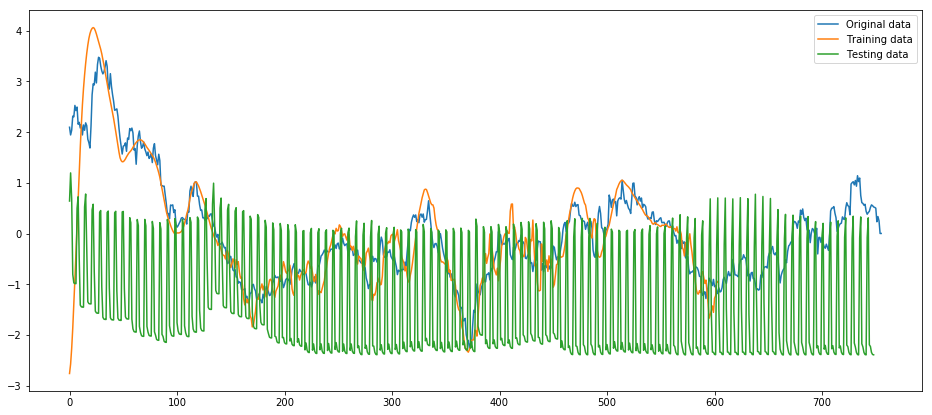

In [94]:
for diao in range(o.shape[0]):
    tests.append(o[diao])
plt.figure(figsize=(16, 7))
plt.plot(scaled_data, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(tests, label='Testing data')
plt.legend()
plt.show()

In [ ]:
 """
            if epoch % 10 ==0:
                is_training = False
                mse = loss.eval(feed_dict={X_:X, Y_:Y})
                print(epoch, "MSE:", mse)
                if mse < best_loss:
                    save_path = saver.save(sess, "./stock.ckpt")
                    best_loss = mse
                    without_process = 0
                else:
                    without_process += 1
                    if without_process > max_tolerate:
                        print("early stop")
                        break
                if best_loss != np.infty:
                    print("{}\tLocal loss:{:.6f}\tBest loss:{:.6f}".format(epoch,mse,best_loss))
            """

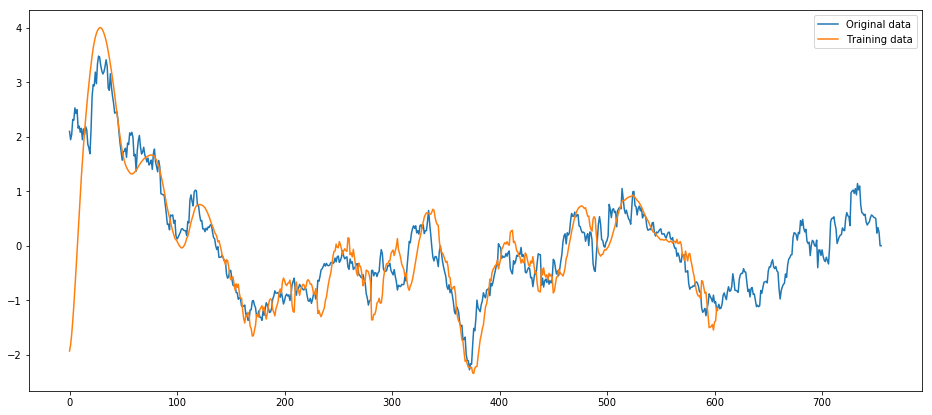

In [85]:
plt.figure(figsize=(16, 7))
plt.plot(scaled_data, label='Original data')
plt.plot(sup, label='Training data')
#plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()

In [72]:
traind_scores

[array([[ 3.36621785],
        [ 3.21843648],
        [ 3.04595041],
        [ 2.74183226],
        [ 3.15928364],
        [ 2.84882498],
        [ 2.63310957]], dtype=float32), array([[ 3.36621785],
        [ 3.21843648],
        [ 3.04595041],
        [ 2.74183226],
        [ 3.15928364],
        [ 2.84882498],
        [ 2.63310957]], dtype=float32), array([[ 3.36621785],
        [ 3.21843648],
        [ 3.04595041],
        [ 2.74183226],
        [ 3.15928364],
        [ 2.84882498],
        [ 2.63310957]], dtype=float32), array([[ 3.36621785],
        [ 3.21843648],
        [ 3.04595041],
        [ 2.74183226],
        [ 3.15928364],
        [ 2.84882498],
        [ 2.63310957]], dtype=float32), array([[ 3.36621785],
        [ 3.21843648],
        [ 3.04595041],
        [ 2.74183226],
        [ 3.15928364],
        [ 2.84882498],
        [ 2.63310957]], dtype=float32), array([[ 3.36621785],
        [ 3.21843648],
        [ 3.04595041],
        [ 2.74183226],
        [ 3.15928364],



0 0

0 1

0 2

0 3

0 4

0 5

0 6

1 0

1 1

1 2

1 3

1 4

1 5

1 6

2 0

2 1

2 2

2 3

2 4

2 5

2 6

3 0

3 1

3 2

3 3

3 4

3 5

3 6

4 0

4 1

4 2

4 3

4 4

4 5

4 6

5 0

5 1

5 2

5 3

5 4

5 5

5 6

6 0

6 1

6 2

6 3

6 4

6 5

6 6

7 0

7 1

7 2

7 3

7 4

7 5

7 6

8 0

8 1

8 2

8 3

8 4

8 5

8 6

9 0

9 1

9 2

9 3

9 4

9 5

9 6

10 0

10 1

10 2

10 3

10 4

10 5

10 6

11 0

11 1

11 2

11 3

11 4

11 5

11 6

12 0

12 1

12 2

12 3

12 4

12 5

12 6

13 0

13 1

13 2

13 3

13 4

13 5

13 6

14 0

14 1

14 2

14 3

14 4

14 5

14 6

15 0

15 1

15 2

15 3

15 4

15 5

15 6

16 0

16 1

16 2

16 3

16 4

16 5

16 6

17 0

17 1

17 2

17 3

17 4

17 5

17 6

18 0

18 1

18 2

18 3

18 4

18 5

18 6

19 0

19 1

19 2

19 3

19 4

19 5

19 6

20 0

20 1

20 2

20 3

20 4

20 5

20 6

21 0

21 1

21 2

21 3

21 4

21 5

21 6

22 0

22 1

22 2

22 3

22 4

22 5

22 6

23 0

23 1

23 2

23 3

23 4

23 5

23 6

24 0

24 1

24 2

24 3

24 4

24 5

24 6

25 0

25 1

25 2

2

264 2

264 3

264 4

264 5

264 6

265 0

265 1

265 2

265 3

265 4

265 5

265 6

266 0

266 1

266 2

266 3

266 4

266 5

266 6

267 0

267 1

267 2

267 3

267 4

267 5

267 6

268 0

268 1

268 2

268 3

268 4

268 5

268 6

269 0

269 1

269 2

269 3

269 4

269 5

269 6

270 0

270 1

270 2

270 3

270 4

270 5

270 6

271 0

271 1

271 2

271 3

271 4

271 5

271 6

272 0

272 1

272 2

272 3

272 4

272 5

272 6

273 0

273 1

273 2

273 3

273 4

273 5

273 6

274 0

274 1

274 2

274 3

274 4

274 5

274 6

275 0

275 1

275 2

275 3

275 4

275 5

275 6

276 0

276 1

276 2

276 3

276 4

276 5

276 6

277 0

277 1

277 2

277 3

277 4

277 5

277 6

278 0

278 1

278 2

278 3

278 4

278 5

278 6

279 0

279 1

279 2

279 3

279 4

279 5

279 6

280 0

280 1

280 2

280 3

280 4

280 5

280 6

281 0

281 1

281 2

281 3

281 4

281 5

281 6

282 0

282 1

282 2

282 3

282 4

282 5

282 6

283 0

283 1

283 2

283 3

283 4

283 5

283 6

284 0

284 1

284 2

284 3

284 4


482 6

483 0

483 1

483 2

483 3

483 4

483 5

483 6

484 0

484 1

484 2

484 3

484 4

484 5

484 6

485 0

485 1

485 2

485 3

485 4

485 5

485 6

486 0

486 1

486 2

486 3

486 4

486 5

486 6

487 0

487 1

487 2

487 3

487 4

487 5

487 6

488 0

488 1

488 2

488 3

488 4

488 5

488 6

489 0

489 1

489 2

489 3

489 4

489 5

489 6

490 0

490 1

490 2

490 3

490 4

490 5

490 6

491 0

491 1

491 2

491 3

491 4

491 5

491 6

492 0

492 1

492 2

492 3

492 4

492 5

492 6

493 0

493 1

493 2

493 3

493 4

493 5

493 6

494 0

494 1

494 2

494 3

494 4

494 5

494 6

495 0

495 1

495 2

495 3

495 4

495 5

495 6

496 0

496 1

496 2

496 3

496 4

496 5

496 6

497 0

497 1

497 2

497 3

497 4

497 5

497 6

498 0

498 1

498 2

498 3

498 4

498 5

498 6

499 0

499 1

499 2

499 3

499 4

499 5

499 6

500 0

500 1

500 2

500 3

500 4

500 5

500 6

501 0

501 1

501 2

501 3

501 4

501 5

501 6

502 0

502 1

502 2

502 3

502 4

502 5

502 6

503 0

503 1


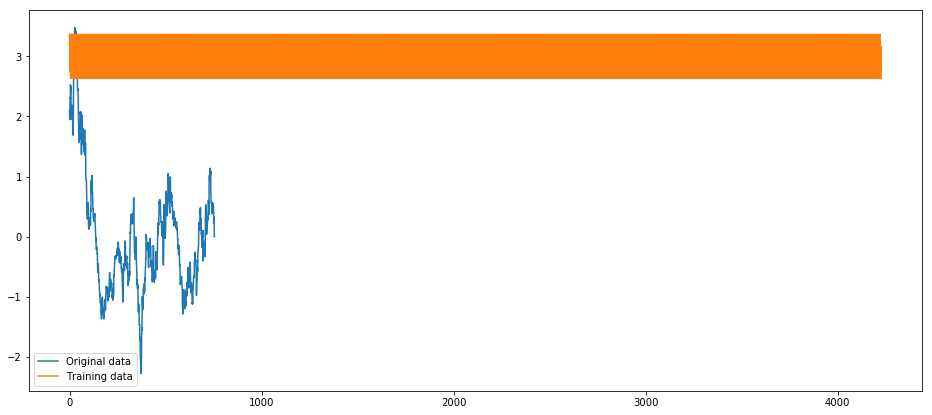

In [76]:
plt.figure(figsize=(16, 7))
plt.plot(scaled_data, label='Original data')
plt.plot(sup, label='Training data')
#plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()

INFO:tensorflow:Restoring parameters from ./stock.ckpt


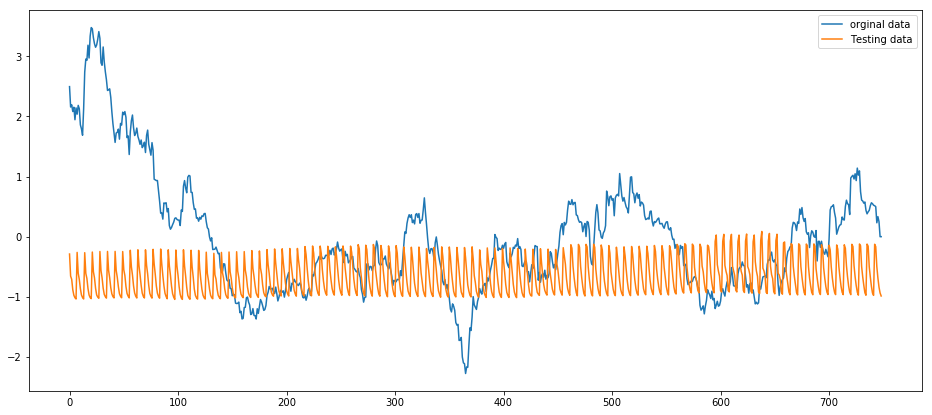

In [68]:
X_plot = np.array(X)
X_plot = X_plot.reshape((-1,7,1))
Y_plot = np.array(Y)
Y_plot = Y_plot.reshape((-1,1))
with tf.Session() as sess:
    saver.restore(sess, "./stock.ckpt")
    Y_final = logits.eval(feed_dict={X_:X_plot})
plt.figure(figsize=(16, 7))
plt.plot(Y_batch, label='orginal data')
plt.plot(Y_final, label='Testing data')
plt.legend()
plt.show()

In [12]:
tf.reset_default_graph()
model = StockPredictionRNN()

Tensor("strided_slice:0", shape=(7, 512), dtype=float32)


In [13]:


session =  tf.Session()



In [14]:
session.run(tf.global_variables_initializer())

In [15]:
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([model.logits, model.loss, model.opt], feed_dict={model.inputs:X_batch, model.targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 30) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.14156904816627502


KeyboardInterrupt: 

Epoch 0/5  Current loss: 0.11411300301551819
Epoch 2/5  Current loss: 0.050170909613370895
Epoch 4/5  Current loss: 0.041502319276332855


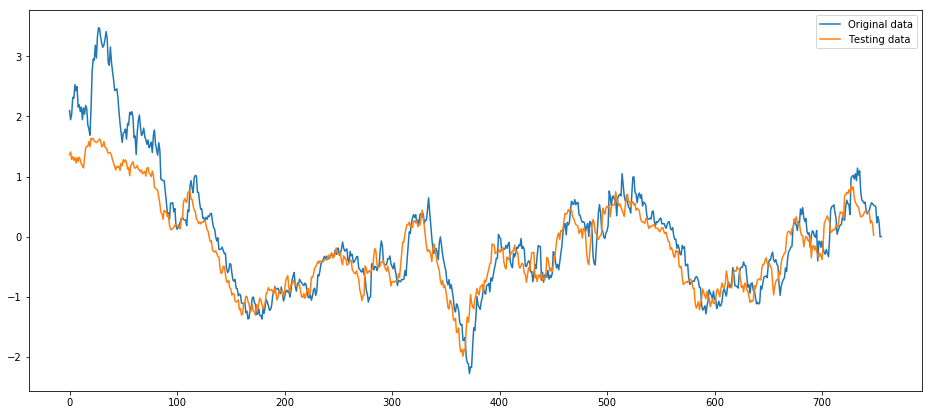

In [136]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

X_train = np.array(X_train)
X_train = X_train.reshape((-1,7,1))
Y_train = np.array(Y_train)
Y_train = Y_train.reshape((-1,1))
epochs = 5
best_loss = np.infty
max_tolerate = 60
with tf.Session() as sess:
    init.run()
    for epoch in range(epochs):
        traind_scores = []
        epoch_loss = []
        for numbe in range(X_train.shape[0]):
            X_batch = np.array(X)
            X_batch = X_batch.reshape((-1,7,1))

            Y_batch = np.array(Y)
            Y_batch = Y_batch.reshape((-1,1))
            X_fan = X_batch[numbe].reshape((-1,7,1))
            Y_fan = Y_batch[numbe].reshape((-1,1))
            a, b, c, d,e = sess.run(
                [outputs, output_change, logits,loss, training_op, ], feed_dict={X_:X_fan, Y_:Y_fan})
            epoch_loss.append(d)
            traind_scores.append(c)
            #print(traind_scores)
        if (epoch % 2) == 0:
            print('Epoch {}/{}'.format(epoch, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
    sup =[]
    for i in range(len(traind_scores)):
        for j in range(len(traind_scores[i])):
                #print()
            sup.append(traind_scores[i][j])
                #print(i,j)
    tests = []
    diao = 0
    while diao+1 <= len(X):
        o = sess.run(logits, feed_dict={X_:X[diao:diao+1]})
        diao += 1
        tests.append(o)
    tests_new = []
    for i in range(len(tests)):
        for j in range(len(tests[i][0])):
            tests_new.append(tests[i][0][j])
    test_results = []
    for i in range(749):
        test_results.append(tests_new[i-749])
       
    plt.figure(figsize=(16, 7))
    plt.plot(scaled_data, label='Original data')
    #plt.plot(sup, label='Training data')
    plt.plot(test_results, label='Testing data')
    plt.legend()
    plt.show()

In [137]:
tests

[array([[ 1.36233509]], dtype=float32),
 array([[ 1.41032088]], dtype=float32),
 array([[ 1.28493249]], dtype=float32),
 array([[ 1.33283937]], dtype=float32),
 array([[ 1.27267945]], dtype=float32),
 array([[ 1.31382871]], dtype=float32),
 array([[ 1.22518146]], dtype=float32),
 array([[ 1.31683588]], dtype=float32),
 array([[ 1.24924707]], dtype=float32),
 array([[ 1.32284677]], dtype=float32),
 array([[ 1.28058982]], dtype=float32),
 array([[ 1.20129418]], dtype=float32),
 array([[ 1.18883336]], dtype=float32),
 array([[ 1.14408886]], dtype=float32),
 array([[ 1.31722772]], dtype=float32),
 array([[ 1.48032689]], dtype=float32),
 array([[ 1.50204694]], dtype=float32),
 array([[ 1.50385666]], dtype=float32),
 array([[ 1.58090174]], dtype=float32),
 array([[ 1.49688172]], dtype=float32),
 array([[ 1.63489139]], dtype=float32),
 array([[ 1.61588538]], dtype=float32),
 array([[ 1.63299024]], dtype=float32),
 array([[ 1.58915269]], dtype=float32),
 array([[ 1.5818361]], dtype=float32),
 

Epoch 0/500  Current loss: 1.1171543598175049
Epoch 2/500  Current loss: 1.0430961847305298
Epoch 4/500  Current loss: 1.0249438285827637
Epoch 6/500  Current loss: 1.0179475545883179
Epoch 8/500  Current loss: 1.0019686222076416
Epoch 10/500  Current loss: 0.9944332838058472
Epoch 12/500  Current loss: 0.9878302812576294
Epoch 14/500  Current loss: 0.9739928841590881
Epoch 16/500  Current loss: 0.9523309469223022
Epoch 18/500  Current loss: 0.9282377362251282
Epoch 20/500  Current loss: 0.893040120601654
Epoch 22/500  Current loss: 0.8595204949378967
Epoch 24/500  Current loss: 0.8495426774024963
Epoch 26/500  Current loss: 0.8282787799835205
Epoch 28/500  Current loss: 0.8031143546104431
Epoch 30/500  Current loss: 0.7930851578712463
Epoch 32/500  Current loss: 0.781338095664978
Epoch 34/500  Current loss: 0.7743849754333496
Epoch 36/500  Current loss: 0.815392255783081
Epoch 38/500  Current loss: 0.7992960810661316
Epoch 40/500  Current loss: 0.758647620677948
Epoch 42/500  Current 

Epoch 344/500  Current loss: 0.40722429752349854
Epoch 346/500  Current loss: 0.41617459058761597
Epoch 348/500  Current loss: 0.40925583243370056
Epoch 350/500  Current loss: 0.40224647521972656
Epoch 352/500  Current loss: 0.40215006470680237
Epoch 354/500  Current loss: 0.40262311697006226
Epoch 356/500  Current loss: 0.4009309411048889
Epoch 358/500  Current loss: 0.3991374373435974
Epoch 360/500  Current loss: 0.397356241941452
Epoch 362/500  Current loss: 0.3962589204311371
Epoch 364/500  Current loss: 0.39604994654655457
Epoch 366/500  Current loss: 0.39537864923477173
Epoch 368/500  Current loss: 0.39457643032073975
Epoch 370/500  Current loss: 0.39302071928977966
Epoch 372/500  Current loss: 0.39178168773651123
Epoch 374/500  Current loss: 0.3913448452949524
Epoch 376/500  Current loss: 0.39069244265556335
Epoch 378/500  Current loss: 0.3894539773464203
Epoch 380/500  Current loss: 0.3889029324054718
Epoch 382/500  Current loss: 0.3880108892917633
Epoch 384/500  Current loss: 

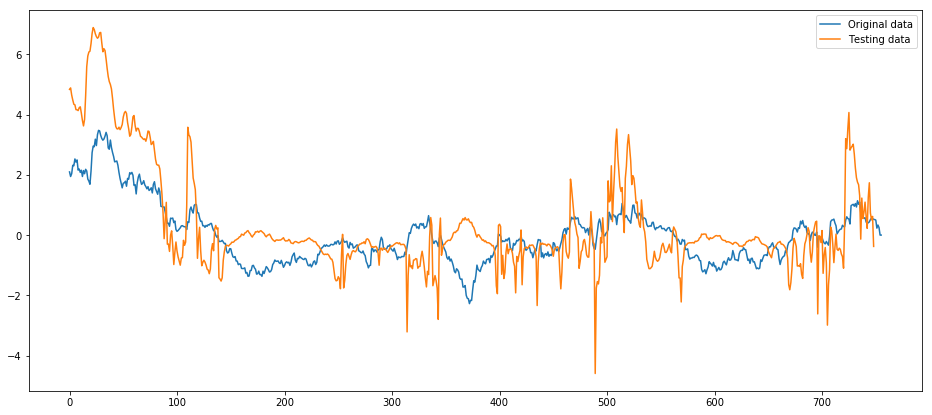

In [143]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

X_train = np.array(X_train)
X_train = X_train.reshape((-1,7,1))
Y_train = np.array(Y_train)
Y_train = Y_train.reshape((-1,1))
epochs = 500
best_loss = np.infty
max_tolerate = 60
with tf.Session() as sess:
    init.run()
    for epoch in range(epochs):
        traind_scores = []
        epoch_loss = []
        X_batch = np.array(X_train)
        X_batch = X_batch.reshape((-1,7,1))

        Y_batch = np.array(Y_train)
        Y_batch = Y_batch.reshape((-1,1))
        #X_fan = X_batch[numbe].reshape((-1,7,1))
        #Y_fan = Y_batch[numbe].reshape((-1,1))
        a, b, c, d,e = sess.run(
            [outputs, output_change, logits,loss, training_op, ], feed_dict={X_:X_batch, Y_:Y_batch})
        epoch_loss.append(d)
        traind_scores.append(c)
        #print(traind_scores)
        if (epoch % 2) == 0:
            print('Epoch {}/{}'.format(epoch, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
    sup =[]
    for i in range(len(traind_scores)):
        for j in range(len(traind_scores[i])):
                #print()
            sup.append(traind_scores[i][j])
                #print(i,j)
    tests = []
    diao = 0
    while diao+1 <= len(X):
        o = sess.run(logits, feed_dict={X_:X[diao:diao+1]})
        diao += 1
        tests.append(o)
    tests_new = []
    for i in range(len(tests)):
        for j in range(len(tests[i][0])):
            tests_new.append(tests[i][0][j])
    test_results = []
    for i in range(749):
        test_results.append(tests_new[i-749])
       
    plt.figure(figsize=(16, 7))
    plt.plot(scaled_data, label='Original data')
    #plt.plot(sup, label='Training data')
    plt.plot(test_results, label='Testing data')
    plt.legend()
    plt.show()